In [70]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

In [71]:
file = pd.read_stata('hctms_data.dta')

## Wybrane zmienne - preprocessing
##### Ilościowe
- **Q21A_Year** - w którym roku badany poznał partnera
- **w6_q9** - wiek partnera w 2017

##### Jakościowe
- **Q27** - czy ty i twój partner dorastaliście w tym samym mieście?
- **w6_q32**- czy wykorzystałeś internet do poznania partnera?

In [72]:
dt = file[['w6_number_people_met','age_when_met','Q9', 'ppage','w6_q32','S1','Q27','w6_q21b_year','w6_q21c_year','Q21A_Year','w6_q9']].dropna().reset_index(drop = True)

In [73]:
# S1 - Is married?
dt['S1'] = 1 - dt['S1'].cat.codes


# w6_q32 - Did you use internet to meet partner?
dt['w6_q32'] = dt['w6_q32'].str.replace('No.*','0')
dt['w6_q32'] = dt['w6_q32'].str.replace('Yes.*','1')
dt = dt.loc[~(dt['w6_q32'] == 'Refused')]
dt['w6_q32'] = pd.to_numeric(dt['w6_q32'])

# Q27 - The same city with partner?
dt['Q27'] = dt['Q27'].str.replace('No.*','0')
dt['Q27'] = dt['Q27'].str.replace('Yes.*','1')
dt = dt.loc[~(dt['Q27'] == 'Refused')]
dt['Q27'] = pd.to_numeric(dt['Q27'])

# Q21A_Year - In what Year and Month did you first meet 
dt = dt.loc[~(dt['Q21A_Year'] == 'Refused')]
dt['Q21A_Year'] = pd.to_numeric(dt['Q21A_Year'])

# w6_q9 - Partner age in 2017

features = dt[['Q21A_Year','w6_q9','Q27','w6_q32']]
labels = dt[['S1']]

In [74]:
features.head(10)

,Q21A_Year,w6_q9,Q27,w6_q32
0,1983,52.0,0,0
1,2006,45.0,0,1
2,1983,59.0,0,0
3,1981,60.0,0,0
4,1966,67.0,1,0
5,1967,65.0,1,0
6,2008,43.0,0,0
7,2007,35.0,0,0
8,2002,42.0,0,0
9,2007,37.0,0,0


## Modele

In [75]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.10, random_state = 0)

### Random Forests

In [76]:
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(train_features, train_labels)

predictions = model_rf.predict(test_features)
tested_labels = np.array(test_labels)

# Zbadanie skuteczności modelu
from sklearn.model_selection import cross_validate
cv_scores = cross_validate(model_rf, train_features, train_labels, cv = 4)
print('Skuteczność modelu to : '+'%2.2f' % (cv_scores['test_score'].mean()*100)+' %')

Skuteczność modelu to : 81.78 %


### SVM

In [115]:
from sklearn.svm import SVC
model_svm = SVC(C=5, gamma='scale', probability=True)
model_svm.fit(train_features, train_labels)

predictions = model_rf.predict(test_features)
tested_labels = np.array(test_labels)

# Zbadanie skuteczności modelu
from sklearn.model_selection import cross_validate
cv_scores = cross_validate(model_svm, train_features, train_labels, cv = 4)
print('Skuteczność modelu to : '+'%2.2f' % (cv_scores['test_score'].mean()*100)+' %')

Skuteczność modelu to : 83.64 %


### Reszty na zbiorze treningowym i scatter plot z predictions

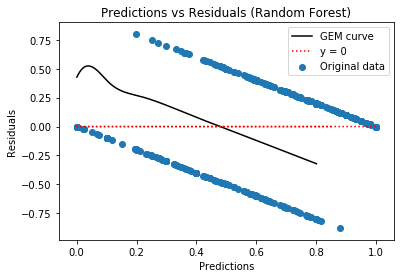

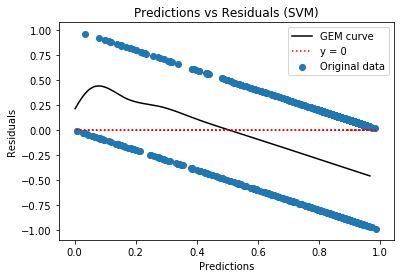

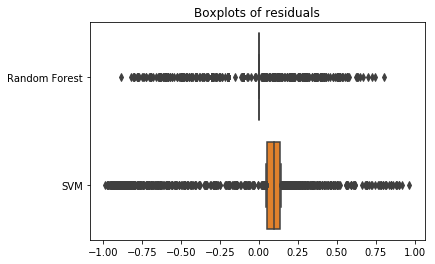

In [161]:
def plot_residuals(model, train_features, train_labels,model_name):
    predictions = model.predict_proba(train_features)[:,1].reshape(len(train_labels),1)
    tested_labels = np.array(train_labels)
    # Residuals
    predictions = predictions.reshape(len(predictions),1)
    residuals = tested_labels - predictions

    # Smooth
    from pygam import LinearGAM
    gam = LinearGAM().fit(residuals.flatten(),predictions.flatten())
    XX = gam.generate_X_grid(term=0, n = 1000)
    smooth_index = XX > 0
    x_smooth = XX[smooth_index]
    y_smooth = gam.partial_dependence(term=0, X=XX)[smooth_index.flatten()]

    # Zero line
    zeros = np.repeat(0,len(predictions))

    plt.scatter(predictions, residuals, label = 'Original data')
    plt.plot(x_smooth,y_smooth, 'black', label = 'GEM curve')
    plt.plot(predictions, zeros, 'r:', label = 'y = 0')
    plt.title('Predictions vs Residuals ('+str(model_name)+')')
    plt.xlabel('Predictions')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()
    
plot_residuals(model_rf, train_features, train_labels, 'Random Forest')
plot_residuals(model_svm, train_features, train_labels, 'SVM')

tested_labels = np.array(train_labels)
predictions_rf = model_rf.predict_proba(train_features)[:,1].reshape(len(train_labels),1)
predictions_svm = model_svm.predict_proba(train_features)[:,1].reshape(len(train_labels),1)
residuals = [tested_labels - predictions_rf,
             tested_labels - predictions_svm]
import seaborn as sns
sns.boxplot(data=residuals, orient='h', whis=0.1)
plt.yticks(plt.yticks()[0], ['Random Forest','SVM'])
plt.title('Boxplots of residuals')
plt.show()

### Reszty na zbiorze treningowym i scatter plot ze zmienną zależną

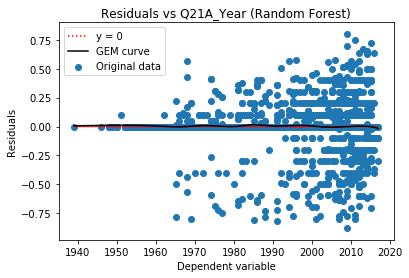

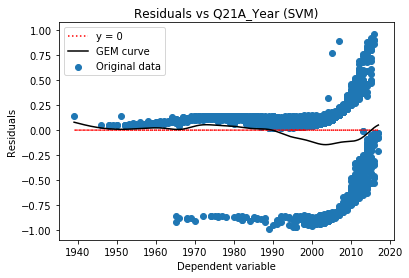

In [147]:
def plot_residuals_variable(model, train_features, train_labels, model_name, variable_name):
    predictions = model.predict_proba(train_features)[:,1].reshape(len(train_labels),1)
    tested_labels = np.array(train_labels)

    # Residuals
    predictions = predictions.reshape(len(predictions),1)
    residuals = tested_labels - predictions

    # Dependent variable
    dep_var = np.array(train_features[variable_name]).reshape(len(train_labels),1)

    # Smooth
    from pygam import LinearGAM
    gam = LinearGAM().fit(dep_var,residuals)
    XX = gam.generate_X_grid(term=0, n = 1000)
    smooth_index = XX > 0
    x_smooth = XX[smooth_index]
    y_smooth = gam.partial_dependence(term=0, X=XX)[smooth_index.flatten()]

    # Zero line
    zeros = np.repeat(0,len(predictions))

    plt.scatter(dep_var, residuals, label='Original data')
    plt.plot(dep_var, zeros, 'r:', label = 'y = 0')
    plt.plot(x_smooth,y_smooth,'black', label = 'GEM curve')
    plt.xlabel('Dependent variable')
    plt.ylabel('Residuals')
    plt.title('Residuals vs '+str(variable_name)+' ('+str(model_name)+')')
    plt.legend()
    plt.show()
    
plot_residuals_variable(model_rf, train_features, train_labels, 'Random Forest', 'Q21A_Year')
plot_residuals_variable(model_svm, train_features, train_labels, 'SVM', 'Q21A_Year')

### Wartość Cook'a dla wszyskich obserwacji

In [102]:
predictions_all_features = model_rf.predict_proba(train_features)[:,1].reshape(len(train_labels),1)

In [112]:
from sklearn.metrics import mean_squared_error

def one_cooks_value(model,features, labels, indx, predictions_all_features):
    no_features = features.drop(indx, axis=0)
    no_labels = labels.drop(indx, axis=0)
    
    model = RandomForestClassifier()
    model.fit(no_features, no_labels)

    predictions_no_features = model.predict_proba(features)[:,1].reshape(len(features),1)
    tested_labels = np.array(labels)
    cook = np.sqrt(np.mean(pow(predictions_all_features - predictions_no_features,2)))
    # mse = mean_squared_error(tested_labels,predictions_all_features)

    return cook #/(features.shape[1]*mse)

def cooks_value(model, features, labels):
    """
    features and labels must have reset index 0 - n
    """
    predictions_all_features = model.predict_proba(features)[:,1].reshape(len(labels),1)
    
    cooks_values = []
    for i in range(len(labels)):
        cooks_values.append(one_cooks_value(model, features, labels, i, predictions_all_features))
    return cooks_values

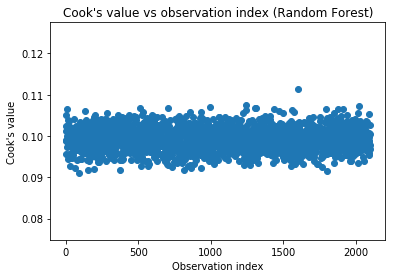

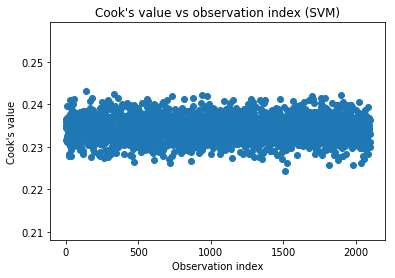

In [148]:
train_features = train_features.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)

cooks_values_rf = cooks_value(model_rf, train_features, train_labels)
cooks_values_svm = cooks_value(model_svm, train_features, train_labels)

plt.scatter(np.arange(0,train_features.shape[0]), cooks_values_rf)
plt.xlabel('Observation index')
plt.ylabel('Cook\'s value' )
plt.title('Cook\'s value vs observation index (Random Forest)')
plt.show()

plt.scatter(np.arange(0,train_features.shape[0]), cooks_values_svm)
plt.xlabel('Observation index')
plt.ylabel('Cook\'s value' )
plt.title('Cook\'s value vs observation index (SVM)')
plt.show()

## Wnioski

Zmienne ciągłe które wybrałem do analizy są dosyć specyficzne. Jest to wiek w którym poznano partnera i rok urodzenia partnera,  prawie pewne jest że wśród tych danych nie wystąpią wartości odstające.

Postanowiłem porównać 2 modele mocno różniące się strukturą:
- Random Forest: Accuracy **81.78%**
- SVM: Accuracy **83.64%**

Można uznać, że korzystając z SVM, uzyskamy delikatnie lepsze wyniki.

**Reszty:**<br/>
Dla obu modeli wykresy reszt są bardzo podobne, jednak z boxplota wynika że Random Forest jest bardziej stabilny niż SVM. 

**Reszty vs Rok w którym badany poznał partnera**<br/>
Na tym wykresie bardzo dobrze widać różnicę między modelami, w Random Forest reszty są praktycznie idealnie rozproszone wzdłuż zera, natomiast przy SVM widać rozdzielenie na 2 grupy, co wynika z konstrukcji modelu. Powoduje to też, że krzywa lokalnego trendu różni się trochę bardziej od prostej równej zero.

**Wartości Cook'a**<br/>
Wartości Cook'a mają pomóc w odkryciu obserwacji odstających, więc zgodnie z oczekiwaniami zmienne, które wykorzystałem do analizy nie przejawiają takich zachowań. Wartości Cook'a wyglądają jak szum, o dosyć małej wariancji, skupiony wokół stałej liczby.

**Wybór modelu**<br/>
Bazując na powyższych wynikach, wybrałbym model Random Forest, ponieważ zachowuje się stabilniej niż SVM.